In [1]:
# remaining challeneges

# upload to github
# label all figures
# set seeds
# consistent colours with hdbscsn as new data arrives?
# for loop over DOFs (vehicles)
# record library versions
# explicitly make the cut at 60 Hz

# remember bootstrap update is in two locations because u dont have for loop

# Testing stuff

In [2]:
pwd

'/Users/prasad/Documents/Mehri_International_Collab/github/VBI_UMAP_HDBSCAN'

In [3]:
print('hey there this is a test')

hey there this is a test


In [1021]:
import pandas as pd
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import umap
import scipy.io
from scipy import signal
from scipy.linalg import svd
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from numpy.random import permutation
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, Normalizer, MaxAbsScaler
import random 
import collections 
from sklearn.svm import OneClassSVM 
from collections import Counter
from scipy import stats as st

import matplotlib as mpl
mpl.rcParams['figure.figsize']=[15, 10]
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.weight'] = 'bold'
plt.rcParams["axes.labelweight"] = "bold"
mpl.rcParams['font.size'] = '32'   # 32 before # 22 for the bad case
mpl.rcParams['axes.grid'] = True
mpl.rcParams['figure.autolayout'] = True

# Utility Functions

In [1022]:
# https://stackoverflow.com/questions/11955000/how-to-preserve-matlab-struct-when-accessing-in-python
def _check_keys( dict):
    """
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    """
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict


def _todict(matobj):
    """
    A recursive function which constructs from matobjects nested dictionaries
    """
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict


def loadmat(filename):
    """
    this function should be called instead of direct scipy.io .loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    """
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)




## Utility Functions (Reading in Data)

In [1023]:
def read_data_fft(Bridge_Type, Damage_Location, Vehicle_Type, Bridge_Profile, 
                  Damage_Levels = ['DM00', 'DM20', 'DM40'], 
                  NUM_DATA_IN_DIR = 400 , 
                  DATA_ROOT_LOC = 'data/', 
                  NFFT=2**7):

    
    if Vehicle_Type == 'V1':
        DOF = 2
    elif Vehicle_Type == 'V2':
        DOF = 4
    else:
        DOF = 8
        
    # List of Dicts 
    # len(list) = num DOFs
    # Each element in list (dict) is the data for one damage level
    data_dict_DOFS = []
    for _ in range(DOF):
        data_dict_DOFS.append({})
    
    for i in range(len(Damage_Levels)):
        str_root_location = Bridge_Type + '/' + Damage_Location + '/' + Damage_Levels[i] + '/' + Vehicle_Type + '/' + Bridge_Profile + '/'
        str_root_event_file = Bridge_Type + Damage_Location + Damage_Levels[i] + Vehicle_Type + Bridge_Profile + 'E'
        
        # List of Lists
        # len(list) = num DOFs
        # Each element in list (another list) stores the data for one damage level
        # This gets reset per damage level (the history of features per damage level)
        # Is designed to be stored in the outer dictionary
        event_list_DOFS = []
        for _ in range(DOF):
            event_list_DOFS.append([])
        
        # For each event
        for j in range(1,NUM_DATA_IN_DIR+1): 
            data_str = DATA_ROOT_LOC + str_root_location + str_root_event_file + f'{j:04d}' + '.mat'
            data_read = loadmat(data_str)
            
            start_pos = data_read['Event']['Veh']['Pos']['t0_ind_beam']
            end_pos = data_read['Event']['Veh']['Pos']['t_end_ind_beam']
            data_matrix = data_read['Event']['Sol']['Veh']['A'][:,start_pos:end_pos] # important to keep start:end range
                        
            features = fft_feature_engineering(data_matrix, nfft=NFFT)
            # Keep accumulating the features, across event, for each observed DOF, at a specific damage level
            for dof_num in range(DOF):
                event_list_DOFS[dof_num] += [features[dof_num,:]]

            
            if j%50 == 0: print(f'Processed Event {j} from damage level {Damage_Levels[i]}')
            
        for dof_num in range(DOF):
            data_dict_DOFS[dof_num][Damage_Levels[i]] = np.array(event_list_DOFS[dof_num] )
        
        print()
        
    print( f'Finished processing information from:\n'
           f'Bridge - {Bridge_Type}\n'
           f'Location - {Damage_Location}\n' 
           f'Vehcile Type - {Vehicle_Type}\n'
           f'Road Profile - {Bridge_Profile}!\n\n')
    
    return data_dict_DOFS

# Pre-processing Functions

In [1024]:
def fft_feature_engineering(data_array, nfft):
    '''
    Refers to one observed car data point (one row of input file)
    data_array.shape = (DOFs, end_pos-start_pos)
    '''
    # TODO: Consider about the order of the sum then the log -- is there some theoretical comment here?
    return fft(data_array - data_array.mean(axis=1).reshape(-1,1), axis=1, n=nfft)[:,:nfft//2]
    
    
def log_abs_transform(data):
    return np.log(np.abs(data))


def bootstrap_sampling(data_array_ffts, sample_times=1000):
    '''
    Assumes all the data have been collected into their own post fft [N x nfft] arrays / DOF

    idxs <-- randperm(N)
    train / test / val split (idxs)

    Splits generated once to avoid train-val-test split data leakage problems.
    '''
    

    # Wilcox(2010) writes "599 is recommended for general use."
    # Wilcox, R. R. (2010). Fundamentals of modern statistical methods: Substantially improving power and accuracy. Springer.
    
    num_data, array_length = data_array_ffts.shape # shape of input data
    idxs = permutation(num_data) # random permutation over the indices
    
      
    data_bootstrap_samples = []

    for _ in range(sample_times):
        idxs_resample = resample(idxs)
        data_bootstrap_samples.append(np.mean(data_array_ffts[idxs_resample,:], axis=0))

    return [np.array(data_bootstrap_samples)]



### I need to see which sections have the majority of the [0,1,2] splits
# and not just see "which is the first one to appear"
def remap(clustering_labels):
    '''
    remap clustering to reflect order of appearance
    '''
    remaped_indices = []
    _, idx_order = np.unique(clustering_labels,return_index=True)
    value_order = list(clustering_labels[np.sort(idx_order)])
        
    print(idx_order)
    print(value_order)
    if -1 in value_order: value_order.remove(-1)
    
    print(value_order)
    for L in clustering_labels:
        if L == -1: 
            remaped_indices.append(-1)
            continue
        count = 0
        for val in value_order:
            if val == L:
                remaped_indices.append(count)
            count += 1
        
    return remaped_indices
            

# Methodology Functions

In [1025]:
# Needs updating of default values
def theoretical_clustering(data,
                           n_healthy,
                           n_mod,
                           n_large,
                           n_components = 2, 
                           n_neighbors = 5, 
                           min_dist = 1, 
                           metric = 'manhattan', 
                           set_op_mix_ratio=0.7, 
                           plot_flag=True,
                           print_flag=True,
                           total_obs=5):
    

    '''
    The theoretical grouping to expect, based on a supervised knowledge
    of which data is healthy, moderate damag, and large damage.
    '''
    
    n_data = data.shape[0]
    cs = ['1']*n_healthy + ['2']*n_mod + ['3']*n_large # Theoretical Groupings
    umap_results = {}
    
    for i in range(1,total_obs+1):
        sub_data = data[0:n_data*i//total_obs,:]
        sub_colours = list(map(int,cs))[0:n_data*i//total_obs] # string to int

        umap_obj = umap.UMAP(n_neighbors = n_neighbors, n_components= n_components, 
                             min_dist=min_dist,metric=metric,
                             set_op_mix_ratio=set_op_mix_ratio, random_state=42).fit(sub_data)
        
        data_points = umap_obj.transform(sub_data)

        if plot_flag:
            plt.figure()
            plt.xlabel('X Magnitude')
            plt.ylabel('Y Magnitude')
            
            DM00_flag = True
            DM20_flag = True
            DM40_flag = True
            
            # inefficient looping
            for j, col in enumerate(sub_colours):
                if col == 1:
                    plt.scatter(data_points[j,0],data_points[j,1],c='g',edgecolors='k',s=150,alpha=0.7,
                             label = 'DM00' if DM00_flag else None)
                    DM00_flag = False
                elif col == 2:
                    plt.scatter(data_points[j,0],data_points[j,1],c='b',edgecolors='k',s=150,alpha=0.7,
                            label = 'DM20' if DM20_flag else None)
                    DM20_flag = False
                else:
                    plt.scatter(data_points[j,0],data_points[j,1],c='r',edgecolors='k',s=150,alpha=0.7,
                            label = 'DM40' if DM40_flag else None)
                    DM40_flag = False
                    
            plt.legend()
            leg = plt.legend()
            for lh in leg.legendHandles: 
                lh._sizes = [300]

                    
        if print_flag: print(f'{i}/{total_obs}')
        
        umap_results[f'{i}_Umap_Object'] = umap_obj
        umap_results[f'{i}_Sub_Data_Fit'] = sub_data
        umap_results[f'{i}_Color_Labels'] = sub_colours
        
    return umap_results

In [1026]:
# Needs updating of default values
def HDBSCAN_UMAP_Application(data,
                           n_healthy,
                           n_mod,
                           n_large,
                           n_components = 2, 
                           n_neighbors = 5, 
                           min_dist = 1, 
                           metric = 'manhattan', 
                           set_op_mix_ratio=0.7, 
                           plot_flag=True,
                           print_flag=True,
                           total_obs=2,
                           min_cluster_size=60,
                           remove_outliers=False,
                           remove_misspec=False):
    
    '''
    n_healthy, n_mod, and n_large are ONLY used to assist in plotting. The entire "data" is used in the 
    UMAP and HDBSCAN procedure without knowing the boundaries of healthy->mod->large dam transitions 
    (unlike in the "theoretical_clustering" function.)
    ''' 

    n_data = data.shape[0]

    for i in range(1,total_obs+1):
        sub_data = total_data[0:n_data*i//total_obs,:]

        # Use Manhattan --> higher dim
        umap_obj = umap.UMAP(n_neighbors = n_neighbors, n_components = n_components, 
                             min_dist = min_dist,metric='manhattan',
                             set_op_mix_ratio = set_op_mix_ratio, random_state=42).fit(sub_data)

        data_points = umap_obj.transform(sub_data)


        clusterer = hdbscan.HDBSCAN(metric='euclidean', 
                                    prediction_data=True, 
                                    min_cluster_size = min_cluster_size).fit(data_points)


        if plot_flag:
            plt.figure()
            plt.xlabel('X Magnitude')
            plt.ylabel('Y Magnitude')
            
            DM00_flag = True
            DM20_flag = True
            DM40_flag = True
            Outlier_flag = True
            Misspeficiation_flag = True
            
            healthy_label = None
            mod_label = None
            large_label = None
            outlier_label = -1
                
            if len(clusterer.labels_) <= n_healthy:
                 healthy_label = int(st.mode(clusterer.labels_)[0])
                    
            elif len(clusterer.labels_) <= n_healthy + n_mod:  
                healthy_label = int(st.mode(clusterer.labels_[0:n_healthy])[0])
                mod_label = int(st.mode(clusterer.labels_[n_healthy:-1])[0])
                
            else:
                healthy_label = int(st.mode(clusterer.labels_[0:n_healthy])[0])
                mod_label = int(st.mode(clusterer.labels_[n_healthy:n_healthy+n_mod])[0])
                large_label = int(st.mode(clusterer.labels_[n_healthy+n_mod:-1])[0])

            for j,label in enumerate(clusterer.labels_):
                if label == healthy_label:
                    plt.scatter(data_points[j,0],data_points[j,1],c='g',edgecolors='k',s=150,alpha=0.7,
                             label = 'DM00' if DM00_flag else None)
                    DM00_flag = False
                elif label == mod_label:
                    plt.scatter(data_points[j,0],data_points[j,1],c='b',edgecolors='k',s=150,alpha=0.7,
                                label = 'DM20' if DM20_flag else None)
                    DM20_flag = False  

                elif label == large_label:
                    plt.scatter(data_points[j,0],data_points[j,1],c='r',edgecolors='k',s=150,alpha=0.7,
                            label = 'DM40' if DM40_flag else None)
                    DM40_flag = False
                    
                elif label == outlier_label:
                    if remove_outliers == True:
                        continue
                    plt.scatter(data_points[j,0],data_points[j,1],c='k',edgecolors='k',s=150,alpha=0.3,
                            label = 'Outlier' if Outlier_flag else None)
                    Outlier_flag = False    
                    
                else:
                    if remove_misspec == True:
                        continue
                    plt.scatter(data_points[j,0],data_points[j,1],c='y',edgecolors='k',s=150,alpha=0.3,
                            label = 'Misspecified Point(s)' if Misspeficiation_flag else None)
                    Misspeficiation_flag = False       
                    
            plt.legend()
            leg = plt.legend()
            for lh in leg.legendHandles: 
                lh._sizes = [300]

            
        if print_flag:
            print(f'{i}/{total_obs}')
            
    # Final Clustering and Label Allocations
    return [hdbscan.all_points_membership_vectors(clusterer), clusterer.labels_]

In [1027]:
np.random.seed(0)
random.seed(0)

# Code Starts Here: Reading in Data

In [1028]:
NFFT = 2**7
DATA_ROOT_LOC = 'data/'
NUM_DATA_IN_DIR = 400

Bridge_Type = 'B09'                          # B09 | B15 | B21 | B27 | B33 | B39
Damage_Location = 'DL25'                     # DL25 | DL50
Damage_Levels = ['DM00', 'DM20', 'DM40']     # DM00 ("Healthy") | DM20 | DM40
Vehicle_Type = 'V1'                          # V1 | V2 | V5
Bridge_Profile = 'PA1'                       # P00 | PA1 | PA2




# Not needed right now?
# FS = 512 # Sampling rate [Hz]

In [1029]:
data = read_data_fft(Bridge_Type, Damage_Location, Vehicle_Type, Bridge_Profile,
                    NUM_DATA_IN_DIR = NUM_DATA_IN_DIR , 
                    DATA_ROOT_LOC = DATA_ROOT_LOC, 
                    NFFT=NFFT)

Processed Event 50 from damage level DM00
Processed Event 100 from damage level DM00
Processed Event 150 from damage level DM00
Processed Event 200 from damage level DM00
Processed Event 250 from damage level DM00
Processed Event 300 from damage level DM00
Processed Event 350 from damage level DM00
Processed Event 400 from damage level DM00

Processed Event 50 from damage level DM20
Processed Event 100 from damage level DM20
Processed Event 150 from damage level DM20
Processed Event 200 from damage level DM20
Processed Event 250 from damage level DM20
Processed Event 300 from damage level DM20
Processed Event 350 from damage level DM20
Processed Event 400 from damage level DM20

Processed Event 50 from damage level DM40
Processed Event 100 from damage level DM40
Processed Event 150 from damage level DM40
Processed Event 200 from damage level DM40
Processed Event 250 from damage level DM40
Processed Event 300 from damage level DM40
Processed Event 350 from damage level DM40
Processed Ev

# Analysis

### UMAP PARAMS

In [1030]:
# n_components = 2
# n_neighbors = 30 # 30 is good
# min_dist = 0
# set_op_mix_ratio = 0.95

# total_obs = 2

# min_cluster_size = 60 # make sure to update the functinos default values!!

# sample_times = 1000

### HDBSCAN PARAMS

## Bootstrap PARAMS

In [1031]:
# DL25 / V1 / PA1

n_components = 2
n_neighbors = 60 # 30 is good
min_dist = 0
set_op_mix_ratio = 0.90

total_obs = 2

min_cluster_size = 95

sample_times = 3000

### Analysis - Demo of data pure time domain

### Analysis - Demo of data without Bootstrap

In [1032]:
DOF_NUM = 1

DOF_NUM -= 1

In [1033]:
label_healthy = ['DM00'] 
label_moderate = ['DM20']
label_large = ['DM40']
for i in range(1,50):
    label_healthy += [None]
    label_moderate += [None]
    label_large += [None]

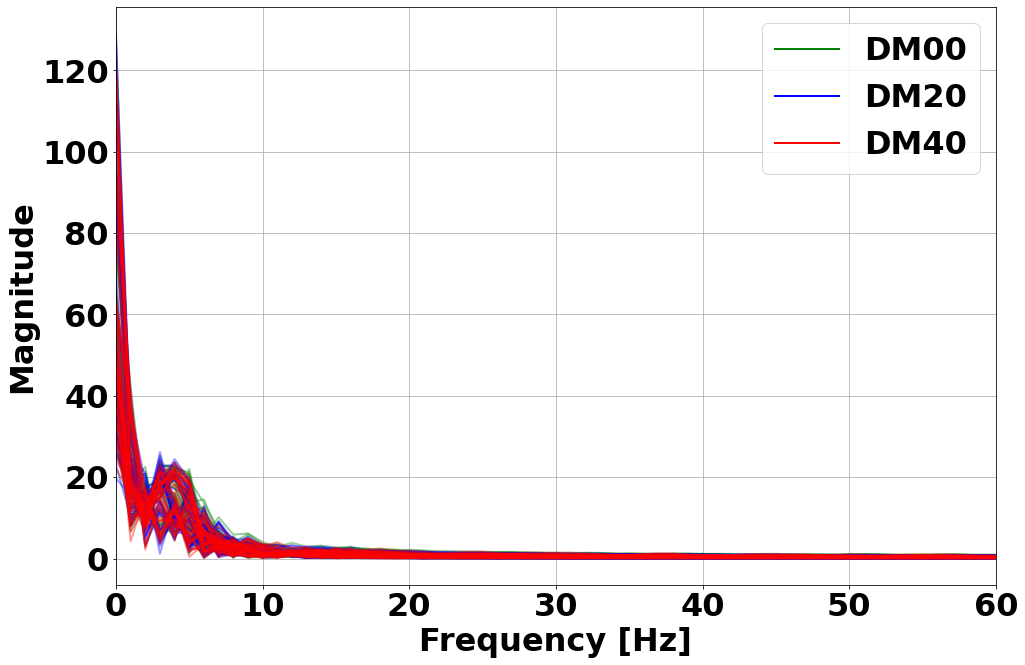

In [1034]:
# [:,1:] indexing due to infinity at first term

# DEMO - NO BOOTSTRAP SAMPLING


# FFT only
plt.plot(abs(data[DOF_NUM]['DM00'][0:50,1:].T),'g', alpha = 0.4, label = label_healthy);
plt.plot(abs(data[DOF_NUM]['DM20'][0:50,1:].T),'b', alpha = 0.4, label = label_moderate);
plt.plot(abs(data[DOF_NUM]['DM40'][0:50,1:].T),'r', alpha = 0.4, label = label_large);
cols = abs(data[DOF_NUM]['DM00'][:,1:].T).shape[1]
# plt.xlim([0,cols])


plt.xlim([0,60])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

### Analysis - Data with Bootstrap

In [1035]:
healthy_data_fft = data[DOF_NUM]['DM00']
mod_data_fft = data[DOF_NUM]['DM20']
large_data_fft = data[DOF_NUM]['DM40']

# Perform bootstrapping
### TESTING INCREASE IN SAMPLE_TIMES
healthy_bootstrap = bootstrap_sampling(healthy_data_fft, sample_times=sample_times) 
mod_bootstrap = bootstrap_sampling(mod_data_fft, sample_times=sample_times) 
large_bootstrap = bootstrap_sampling(large_data_fft, sample_times=sample_times) 

In [1036]:
mod_bootstrap[0].shape

(3000, 64)

In [1037]:
healthy_log_abs_train = log_abs_transform(healthy_bootstrap[0])
mod_log_abs_train = log_abs_transform(mod_bootstrap[0])
large_log_abs_train = log_abs_transform(large_bootstrap[0])

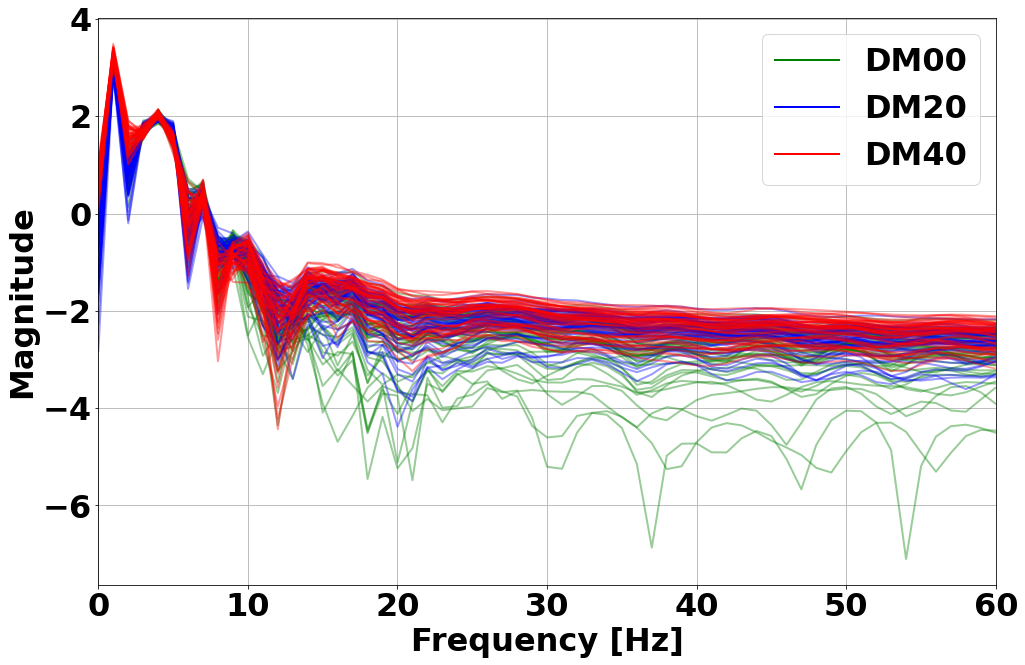

In [1038]:
# plt.plot(data[DOF_NUM]['DM00'][1:200,:].T,'g');  # STILL IN COMPLEX FORM
plt.plot(healthy_log_abs_train[0:50,:].T,'g', label = label_healthy, alpha = 0.4);
plt.plot(mod_log_abs_train[0:50,:].T,'b', label = label_moderate, alpha = 0.4);
plt.plot(large_log_abs_train[0:50,:].T,'r', label = label_large, alpha = 0.4);
plt.xlim([0,60])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

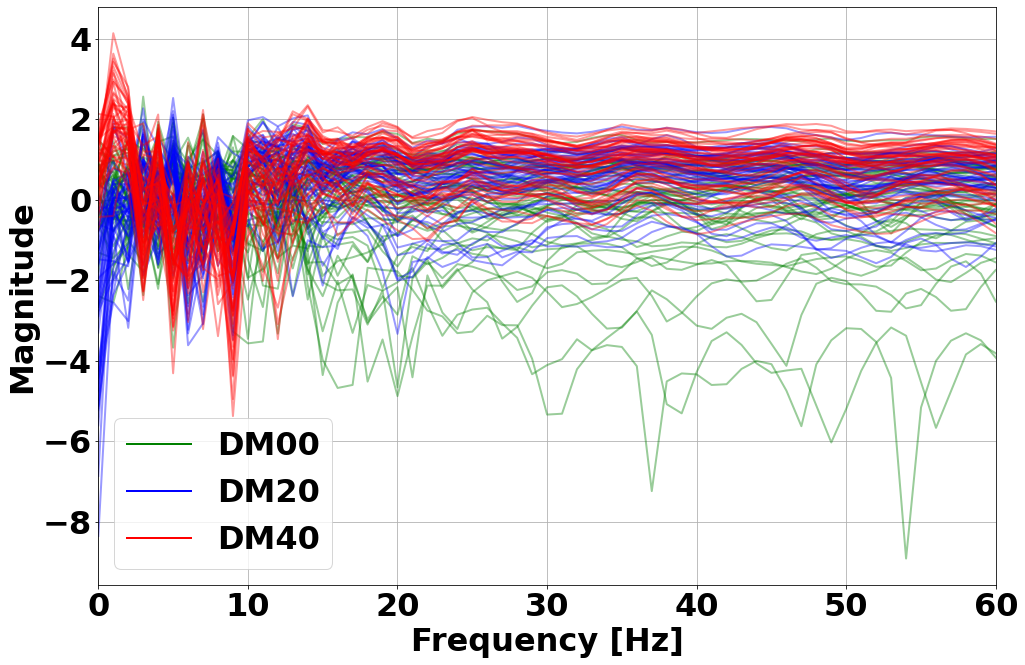

In [1039]:

scaler = StandardScaler()
healthy_scaled = scaler.fit_transform(healthy_log_abs_train) #### You NEED TO MAKE SURE THIS SPLIT IS CONSISTENT E.G. WHEN INPUTING THE DATASTREAMS SEQUENCING
mod_scaled = scaler.transform(mod_log_abs_train)
large_scaled = scaler.transform(large_log_abs_train)


plt.plot(healthy_scaled[0:50,:].T,'g', label = label_healthy, alpha = 0.4);
plt.plot(mod_scaled[0:50,:].T,'b', label = label_moderate, alpha = 0.4);
plt.plot(large_scaled[0:50,:].T,'r', label = label_large, alpha = 0.4);

plt.xlim([0,60])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

1/2
2/2


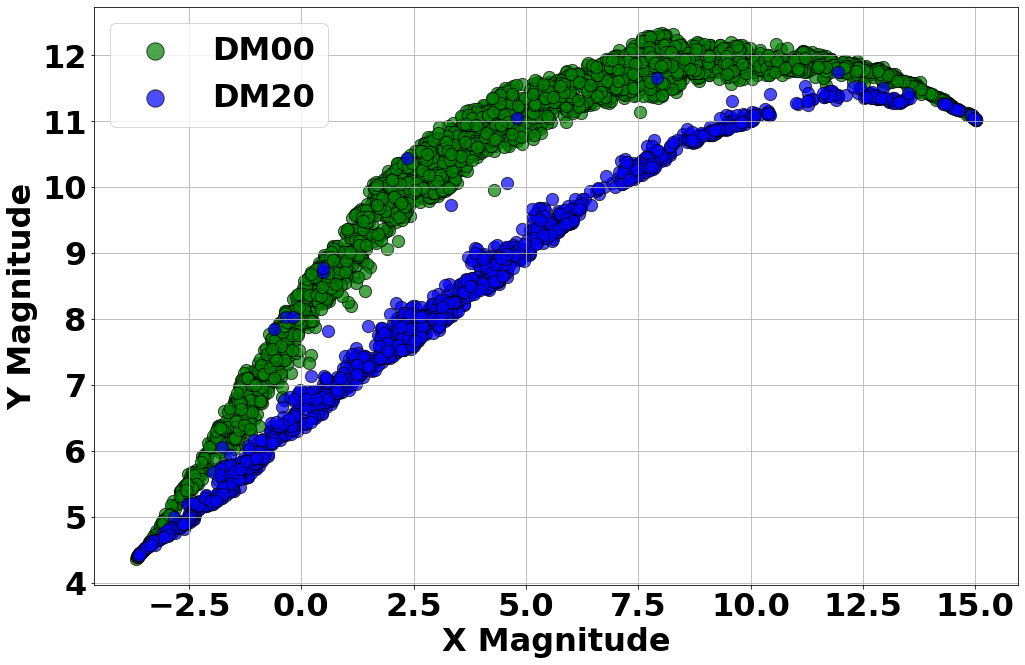

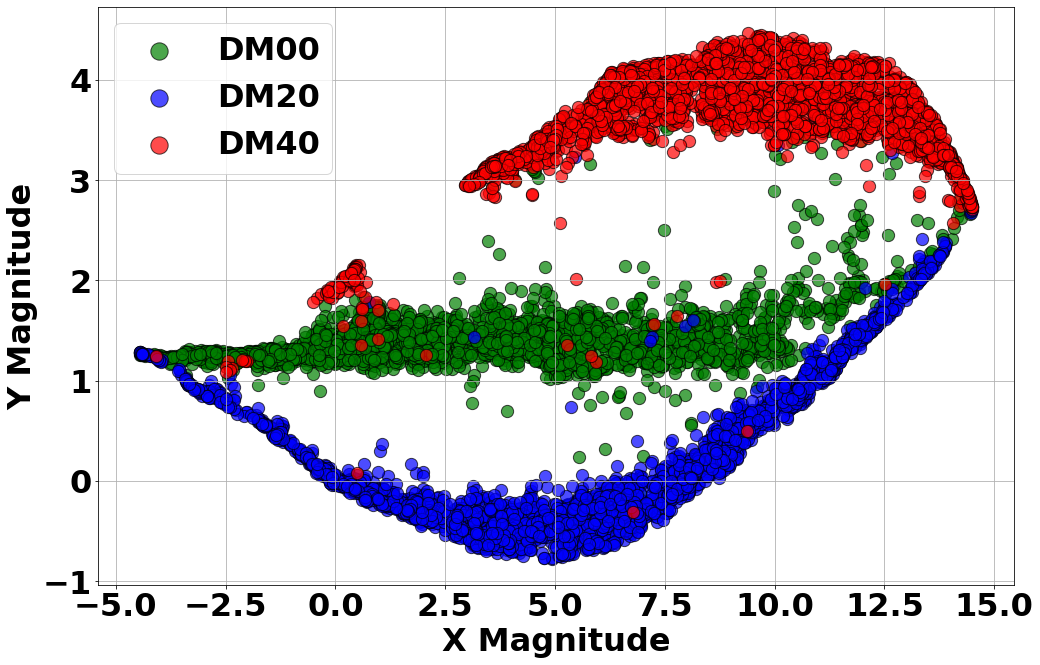

In [1040]:
total_data = np.vstack((healthy_scaled[:,1:], mod_scaled[:,1:], large_scaled[:,1:]))

n_healthy = healthy_scaled[:,1:].shape[0]
n_mod = mod_scaled[:,1:].shape[0]
n_large = large_scaled[:,1:].shape[0]


umap_theoretical_results = theoretical_clustering(total_data, n_healthy, n_mod, n_large, 
                                                  plot_flag=True, print_flag=True,
                                                  n_components = n_components, 
                                                  n_neighbors = n_neighbors,
                                                  min_dist = min_dist,
                                                  set_op_mix_ratio = set_op_mix_ratio,
                                                  total_obs=total_obs);

# HDBSCAN Implementation

Quoting from the paper, “On the Surprising Behavior of Distance Metrics in High Dimensional Space”, by Charu C. Aggarwal, Alexander Hinneburg, and Daniel A. Kiem. “ for a given problem with a fixed (high) value of the dimensionality d, it may be preferable to use lower values of p. This means that the L1 distance metric (Manhattan Distance metric) is the most preferable for high dimensional applications.”

In [1041]:
# min_cluster_size

1/1


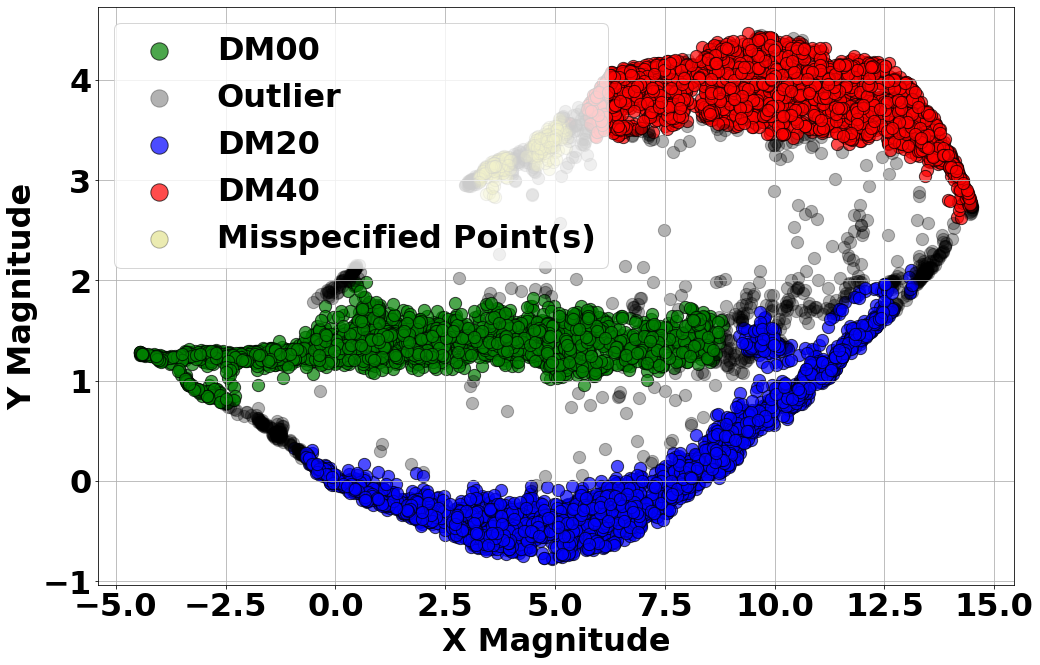

In [1042]:
# Add one to remove "mis-specified points also if wanted"
output_1 = HDBSCAN_UMAP_Application(total_data, n_healthy, n_mod, n_large,
                              plot_flag=True, print_flag=True,
                                n_components = n_components, 
                                n_neighbors = n_neighbors,
                                min_dist = min_dist,
                                set_op_mix_ratio = set_op_mix_ratio,
                                total_obs=1, ############## change back
                                min_cluster_size=min_cluster_size,
                                remove_outliers=False,  # For the difficult case
                                remove_misspec=False); #######################

soft_clusters_1, labels_1 = output_1

## Running Same Thing for Second DoF

In [1043]:
DOF_NUM = 2

DOF_NUM -= 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


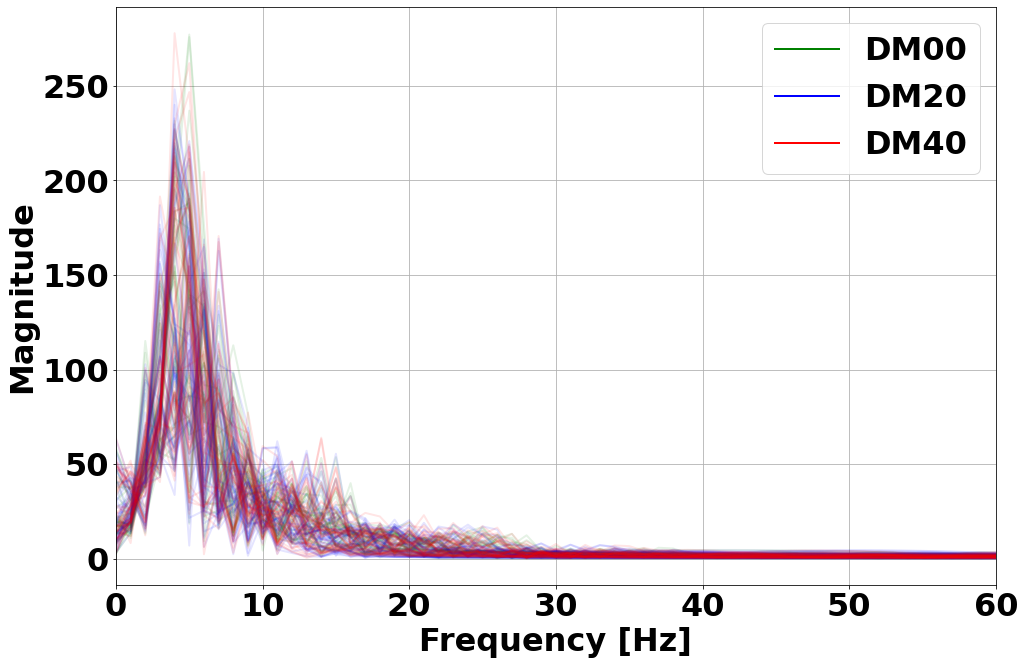

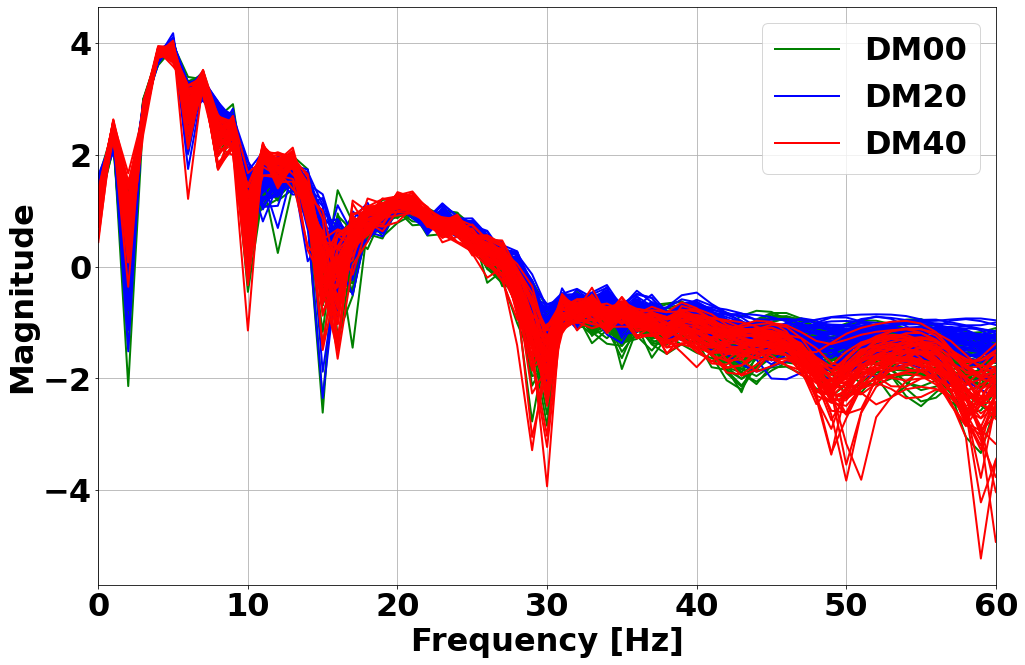

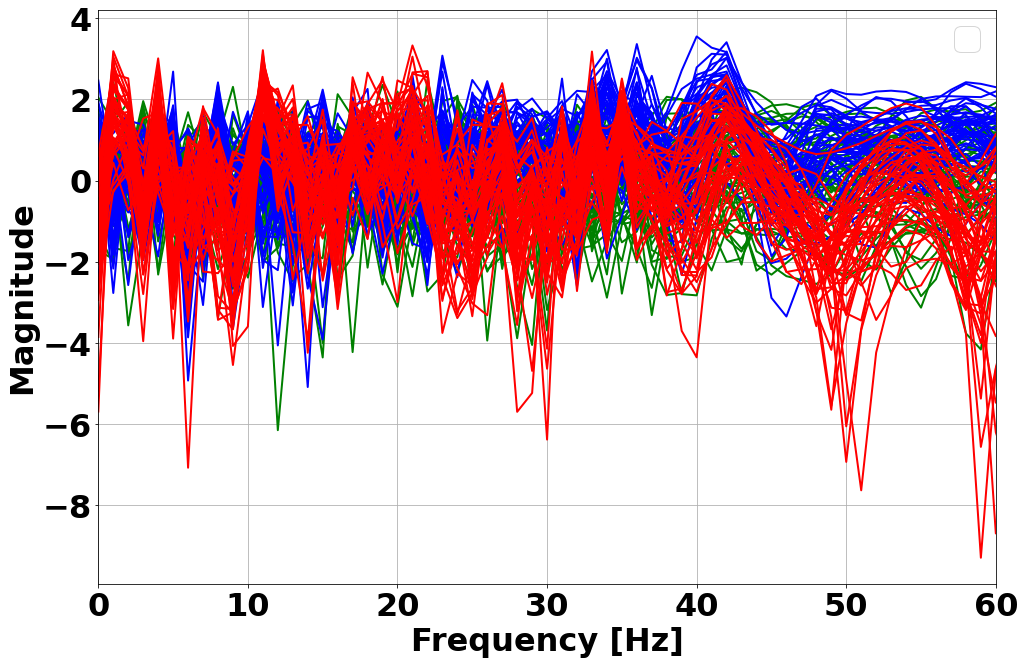

In [1044]:
# FFT only
plt.figure()
plt.plot(abs(data[DOF_NUM]['DM00'][:50,1:].T),'g', alpha = 0.1, label = label_healthy);
plt.plot(abs(data[DOF_NUM]['DM20'][:50,1:].T),'b', alpha = 0.1, label = label_moderate);
plt.plot(abs(data[DOF_NUM]['DM40'][:50,1:].T),'r', alpha = 0.1, label = label_large);
cols = abs(data[DOF_NUM]['DM00'][:,1:].T).shape[1]

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)


plt.xlim([0,60])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')








healthy_data_fft = data[DOF_NUM]['DM00']
mod_data_fft = data[DOF_NUM]['DM20']
large_data_fft = data[DOF_NUM]['DM40']

# Perform bootstrapping
### TESTING INCREASE IN SAMPLE_TIMES
healthy_bootstrap = bootstrap_sampling(healthy_data_fft, sample_times=sample_times) 
mod_bootstrap = bootstrap_sampling(mod_data_fft,  sample_times=sample_times) 
large_bootstrap = bootstrap_sampling(large_data_fft,  sample_times=sample_times) 


healthy_log_abs_train = log_abs_transform(healthy_bootstrap[0])
mod_log_abs_train = log_abs_transform(mod_bootstrap[0])
large_log_abs_train = log_abs_transform(large_bootstrap[0])

plt.figure()
plt.plot(healthy_log_abs_train[0:50,:].T, label = label_healthy, color='g');
plt.plot(mod_log_abs_train[0:50,:].T, label = label_moderate, color='b');
plt.plot(large_log_abs_train[0:50,:].T, label = label_large, color='r');
plt.xlim([0,60])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
    
    


scaler = StandardScaler()
healthy_scaled = scaler.fit_transform(healthy_log_abs_train)
mod_scaled = scaler.transform(mod_log_abs_train)
large_scaled = scaler.transform(large_log_abs_train)


plt.figure()
plt.plot(healthy_scaled[0:50,:].T,'g');
plt.plot(mod_scaled[0:50,:].T,'b');
plt.plot(large_scaled[0:50,:].T,'r');

plt.xlim([0,60])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)


total_data = np.vstack((healthy_scaled[:,1:], mod_scaled[:,1:], large_scaled[:,1:]))

n_healthy = healthy_scaled[:,1:].shape[0]
n_mod = mod_scaled[:,1:].shape[0]
n_large = large_scaled[:,1:].shape[0]

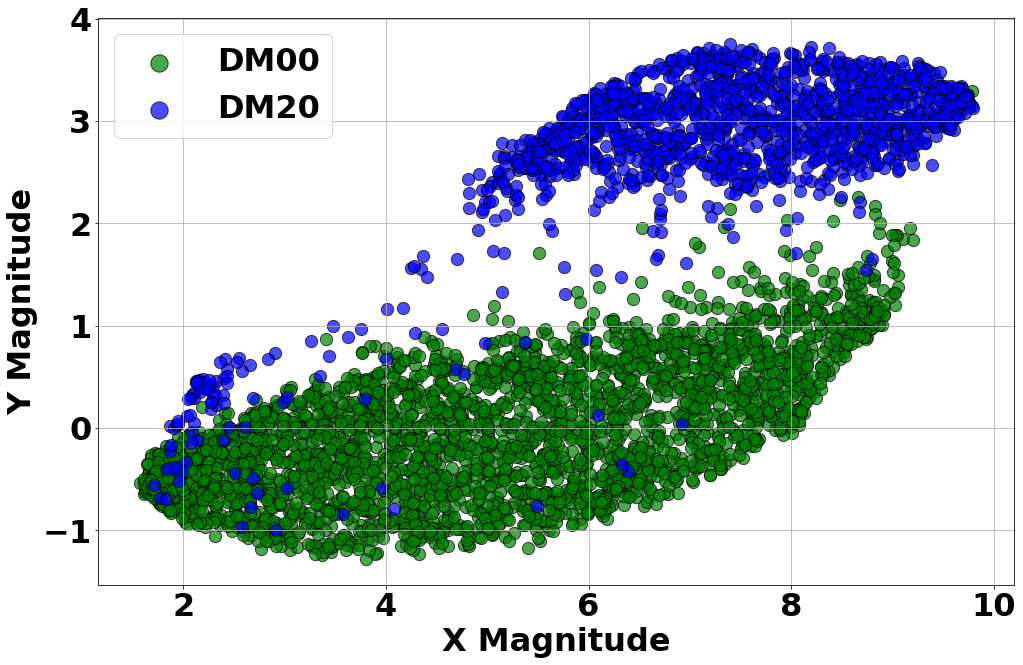

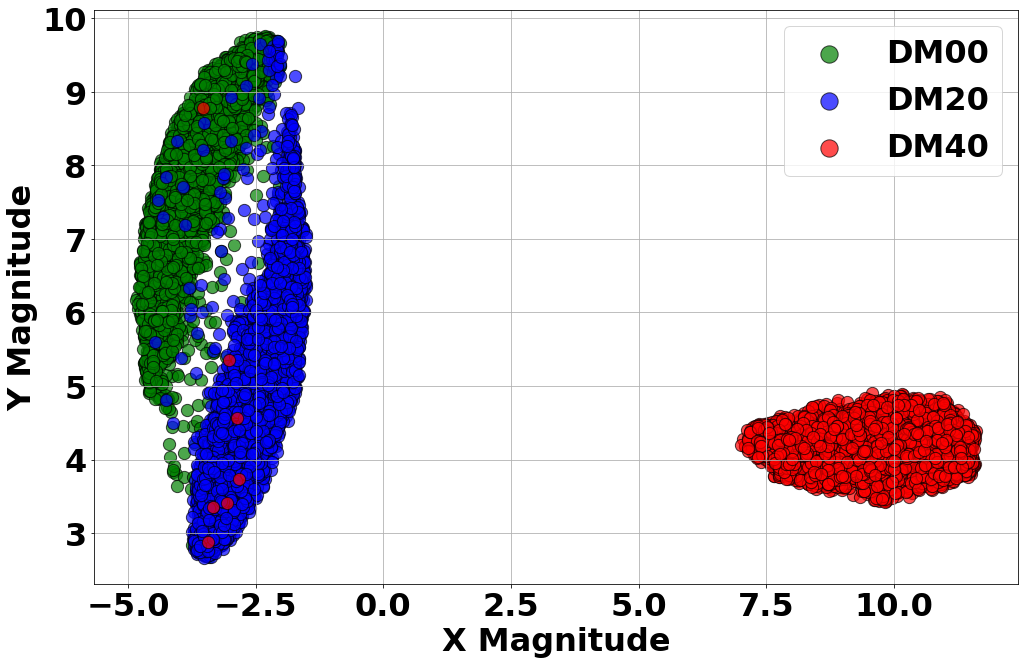

In [1045]:
umap_theoretical_results = theoretical_clustering(total_data, n_healthy, n_mod, n_large, 
                                                  plot_flag=True, print_flag=False,
                                                  n_components = n_components, 
                                                  n_neighbors = n_neighbors,
                                                  min_dist = min_dist,
                                                  set_op_mix_ratio = set_op_mix_ratio,
                                                  total_obs=total_obs);



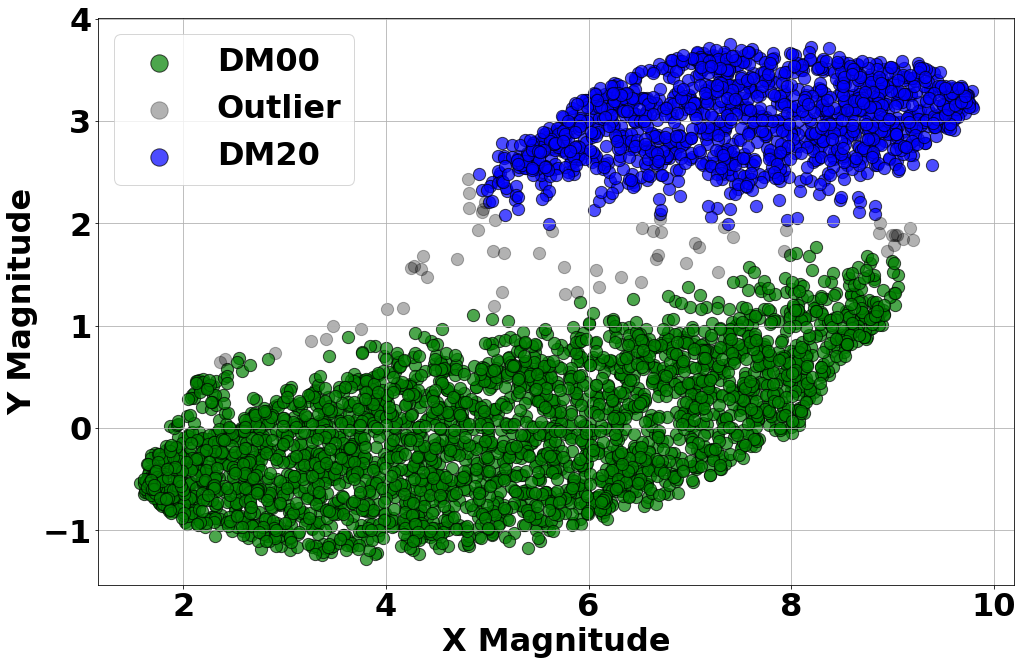

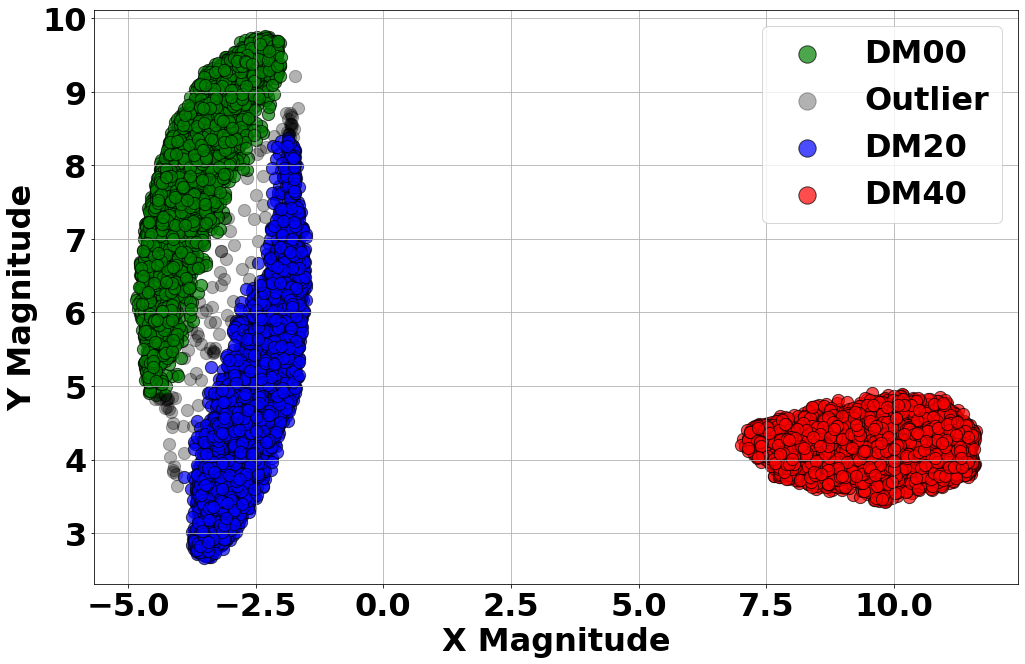

In [1046]:
output_2 = HDBSCAN_UMAP_Application(total_data, n_healthy, n_mod, n_large, 
                              plot_flag=True, print_flag=False,
                                n_components = n_components, 
                                n_neighbors = n_neighbors,
                                min_dist = min_dist,
                                set_op_mix_ratio = set_op_mix_ratio,
                                total_obs=total_obs, 
                                min_cluster_size=min_cluster_size);

soft_clusters_2, labels_2 = output_2

## Testing out Scoring Functions amongst Multiple Clusters

In [1047]:
t = np.array([[0.6,0.4]])

In [1048]:
entropy(t)

array([0.67301167])

In [1049]:
t2 = np.array([[0.9,0.2,0.2,0.2,0.2,0.2]])
entropy(t2)

array([1.70426238])

In [1050]:
def entropy(arr):
    '''
    Assumes 2D array input
    '''
    return -(np.log(arr)*arr).sum(axis=1)

def diff(arr):
    return arr[1:] - arr[0:-1]

In [1051]:
max_ent = entropy(np.ones((1,soft_clusters_1.shape[1]))/soft_clusters_1.shape[1]) + \
          entropy(np.ones((1,soft_clusters_2.shape[1]))/soft_clusters_2.shape[1])

In [1052]:
changes_1 = diff(labels_1)
f_1 = entropy(soft_clusters_1)

test_arr_1 = np.zeros(len(changes_1))
for i in range(len(changes_1)):
    if changes_1[i] == 0:
        continue
    else:
        test_arr_1[i] = f_1[i]

In [1053]:
changes_2 = diff(labels_2)
f_2 = entropy(soft_clusters_2)

test_arr_2 = np.zeros(len(changes_2))
for i in range(len(changes_2)):
    if changes_2[i] == 0:
        continue
    else:
        test_arr_2[i] = f_2[i]

In [1054]:
# Then we can combine entropy scores across each DOF
# Should I consider appeals to softmax / cross-entropy arguments?
# Is there a principled way to combine entropy scores from independednt generating sources?
# https://stats.stackexchange.com/a/100922/117574
# https://en.wikipedia.org/wiki/Joint_entropy#Properties

# plt.title('Generation of New Cluster Detected')
# plt.plot(changes_1) # Has a new cluster formed?
# plt.figure()
# plt.title('Entropy Score of the New Cluster')
# plt.plot(test_arr_1) # What is the quality of the clustering (entropy score)

In [1055]:
# plt.title('Generation of New Cluster Detected')
# plt.plot(changes_2) # Has a new cluster formed?
# plt.figure()
# plt.title('Entropy Score of the New Cluster')
# plt.plot(test_arr_2) # What is the quality of the clustering (entropy score)

In [1056]:
from matplotlib.patches import Rectangle

/Users/prasad/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


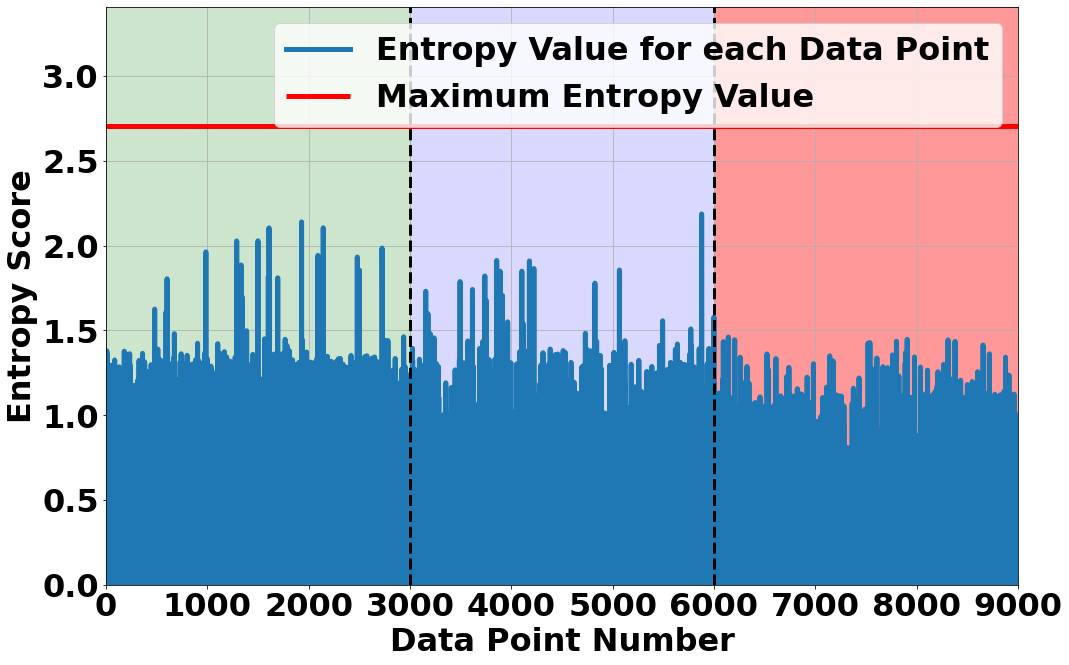

In [1057]:
# plt.title('Total (final) Entropy Scoring')
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(test_arr_1+test_arr_2,linewidth=5,label='Entropy Value for each Data Point') # What is the quality of the clustering (entropy score)

# SHOULD BE TUNED TO BOOTSTRAP LENGTH
xlim_length = soft_clusters_1.shape[0]
plt.hlines(max_ent,0,xlim_length,'r',linewidth=5, label='Maximum Entropy Value')
plt.xlim(0,xlim_length)
plt.ylim(0,max_ent+0.7)

plt.xlabel('Data Point Number')
plt.ylabel('Entropy Score')
plt.legend()

plt.vlines(xlim_length//3, 0,max_ent+0.7, color='k', linestyle='dashed', linewidth=3)
plt.vlines(xlim_length//3*2, 0,max_ent+0.7, color='k', linestyle='dashed', linewidth=3)

rect_DM00 = Rectangle((0.0,0.0),xlim_length//3,max_ent+0.7,color='green',alpha=0.2)
rect_DM20 = Rectangle((xlim_length//3,0.0),xlim_length//3,max_ent+0.7,color='blue',alpha=0.15)
rect_DM40 = Rectangle((xlim_length//3*2,0.0),xlim_length//3,max_ent+0.7,color='red',alpha=0.4)

ax.add_patch(rect_DM00)
ax.add_patch(rect_DM20)
ax.add_patch(rect_DM40)